In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import dump

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose

MAPE = 0.04928465819628713
MAE = 2290.9900556401562
MSE = 9022763.233540645
R^2: 0.2960982682590675
Корреляция Пирсона: 0.8617542326598603


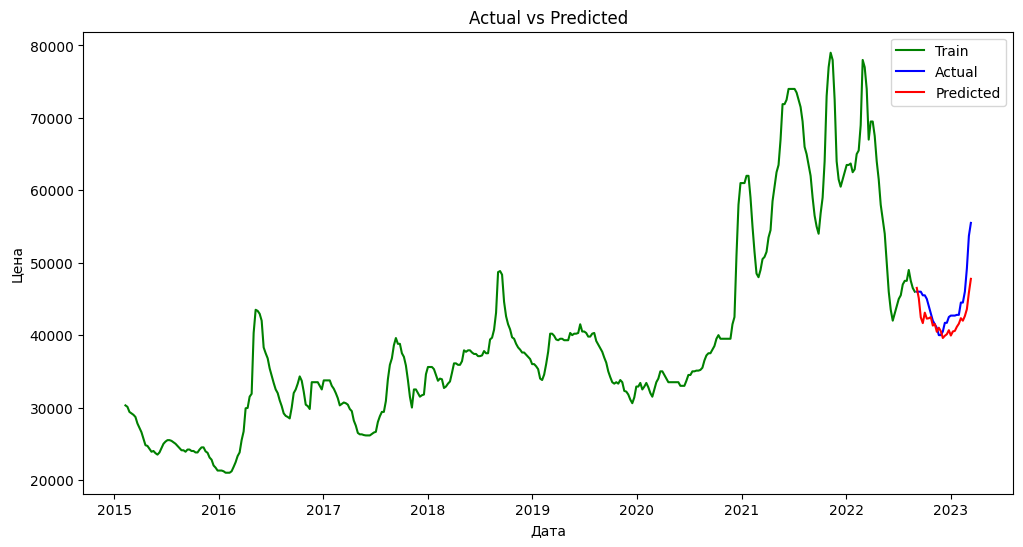

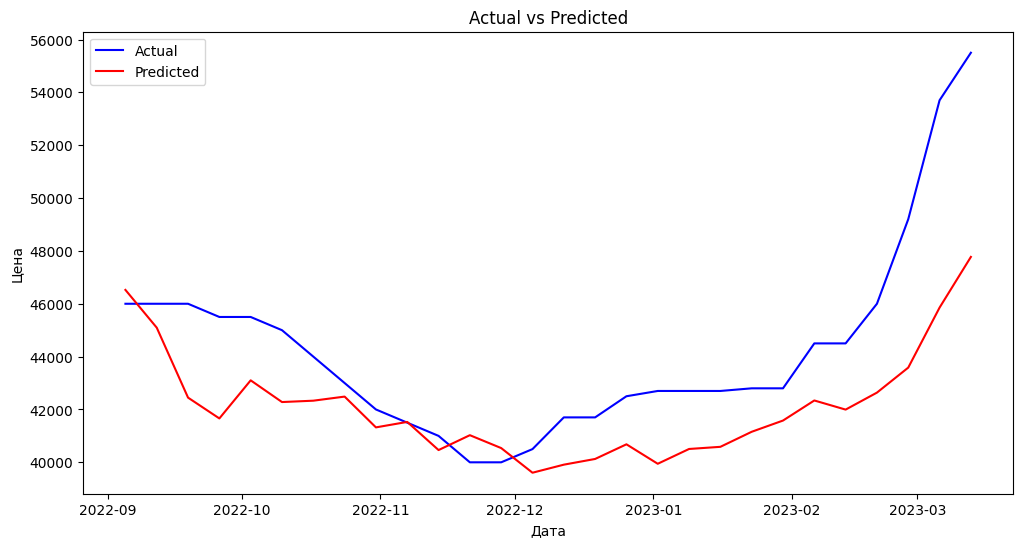

In [ ]:
date = ('2022-09-05 00:00:00')

data = pd.read_csv('data/full.csv')

data.dt = pd.to_datetime(data.dt) # Приводим дату в тип pandas
data = data.set_index('dt') # Делаем колонку даты индексом, даем ей периодичность месяц ('MS' - month start)

decomposition = seasonal_decompose(data['pfr'], model='additive')

data['trend'] = decomposition.trend
data['seasonal'] = decomposition.seasonal
data['residual'] = decomposition.resid

lag_days = 50  # Количество лагов
for lag in range(1, lag_days + 1):
    data[f'lag_{lag}'] = data['pfr'].shift(lag)

t = list(data.columns)
t.remove('pfr')

train = data[data.index < date]
test = data[data.index >= date]

X_train = train[t]
y_train = train['pfr']

X_test = test[t]
y_test = test['pfr']

###############################################################################################

model = CatBoostRegressor(iterations=1952, 
                          depth=4, 
                          learning_rate=0.0013015170249538928, 
                          l2_leaf_reg=3.339004250246249, 
                          verbose=0)

model.fit(X_train, y_train)

dump(model, 'model/catBoostModel.joblib', compress=9)

y_pred = model.predict(X_test)

###############################################################################################

# Оценка модели
print(f"MAPE = {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")
print(f"Корреляция Пирсона: {np.corrcoef(y_test, y_pred)[0, 1]}")

###############################################################################################

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train', color='green')
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

###############################################################################################

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Определяем модель
model = CatBoostRegressor(silent=True)

# Определяем гиперпараметры для подбора
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'iterations': [500, 1000],
}

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1)

# Обучение модели
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение R^2:", grid_search.best_score_)

[I 2025-03-25 04:56:16,798] A new study created in memory with name: no-name-03fb87d9-3698-4e13-8a09-be7f525e7dd4
C:\Users\Shark\AppData\Local\Temp\ipykernel_1780\3665613341.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Shark\AppData\Local\Temp\ipykernel_1780\3665613341.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-1, 10),
[I 2025-03-25 05:01:31,661] Trial 0 finished with value: 0.6686080998246867 and parameters: {'iterations': 2409, 'depth': 12, 'learning_rate': 0.011218512927610792, 'l2_leaf_reg': 1.524532120580666}. B

Лучшие гиперпараметры: {'iterations': 1952, 'depth': 4, 'learning_rate': 0.0013015170249538928, 'l2_leaf_reg': 3.339004250246249}
Лучший R^2: 0.7762785193947521


In [7]:
good = {
    'MAPE':{'qua':0, 'res':float('inf')},
    'MAE':{'qua':0, 'res':float('inf')},
    'MSE':{'qua':0, 'res':float('inf')},
    'correlation':{'qua':0, 'res':float('-inf')},
    'R^2':{'qua':0, 'res':float('-inf')}
}

for i in range(10):

    data = pd.read_csv('data/full.csv')

    data.dt = pd.to_datetime(data.dt) # Приводим дату в тип pandas
    data = data.set_index('dt') # Делаем колонку даты индексом, даем ей периодичность месяц ('MS' - month start)

    lag_days = i  # Количество лагов
    for lag in range(1, lag_days + 1):
        data[f'lag_{lag}'] = data['pfr'].shift(lag)

    t = list(data.columns)
    t.remove('pfr')

    train = data[data.index < date]
    test = data[data.index >= date]

    X_train = train[t]
    y_train = train['pfr']

    X_test = test[t]
    y_test = test['pfr']

    ###############################################################################################

    model = CatBoostRegressor(iterations=study.best_params['iterations'], 
                              learning_rate=study.best_params['learning_rate'], 
                              depth=study.best_params['depth'], 
                              l2_leaf_reg=study.best_params['l2_leaf_reg'],
                              verbose=0)

    model.fit(X_train, y_train)
    plt.show()

    y_pred = model.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    correlation = np.corrcoef(y_test, y_pred)[0, 1]
    r2 = r2_score(y_test, y_pred)

    asist1 = 1 - correlation
    asist2 = 1 - r2

    if good['MAPE']['res'] > mape:
        good['MAPE']['qua'] = i
        good['MAPE']['res'] = mape

    if good['MAE']['res'] > mae:
        good['MAE']['qua'] = i
        good['MAE']['res'] = mae

    if good['MSE']['res'] > mse:
        good['MSE']['qua'] = i
        good['MSE']['res'] = mse

    if good['correlation']['res'] < correlation:
        good['correlation']['qua'] = i
        good['correlation']['res'] = correlation

    if good['R^2']['res'] < r2:
        good['R^2']['qua'] = i
        good['R^2']['res'] = r2

    print('Коэффициент корреляции:', correlation)
    print('R^2:', r2)

    print('-----------------------')
    print(i)
    print(good)
    print('-----------------------')


Коэффициент корреляции: 0.8470100755706351
R^2: 0.7119869344023827
-----------------------
0
{'MAPE': {'qua': 0, 'res': 0.03526848540311302}, 'MAE': {'qua': 0, 'res': 1594.3895424421855}, 'MSE': {'qua': 0, 'res': 3691813.1919157435}, 'correlation': {'qua': 0, 'res': 0.8470100755706351}, 'R^2': {'qua': 0, 'res': 0.7119869344023827}}
-----------------------
Коэффициент корреляции: 0.9033817250093594
R^2: 0.7525306020259278
-----------------------
1
{'MAPE': {'qua': 1, 'res': 0.034102884184440026}, 'MAE': {'qua': 1, 'res': 1526.0884401640335}, 'MSE': {'qua': 1, 'res': 3172115.772388366}, 'correlation': {'qua': 1, 'res': 0.9033817250093594}, 'R^2': {'qua': 1, 'res': 0.7525306020259278}}
-----------------------
Коэффициент корреляции: 0.8732130487281524
R^2: 0.7402108712213156
-----------------------
2
{'MAPE': {'qua': 1, 'res': 0.034102884184440026}, 'MAE': {'qua': 1, 'res': 1526.0884401640335}, 'MSE': {'qua': 1, 'res': 3172115.772388366}, 'correlation': {'qua': 1, 'res': 0.903381725009359

In [8]:
print(good)
print("Лучшие параметры:", study.best_params_)

{'MAPE': {'qua': 3, 'res': 0.029772306466744815}, 'MAE': {'qua': 3, 'res': 1367.7046956990032}, 'MSE': {'qua': 1, 'res': 3172115.772388366}, 'correlation': {'qua': 1, 'res': 0.9033817250093594}, 'R^2': {'qua': 1, 'res': 0.7525306020259278}}


AttributeError: 'Study' object has no attribute 'best_params_'